# Fashion MNIST Data Science Challenge: Neural Networks and Deep Learning


# Labels

Each training and test example is assigned to one of the following labels:

<li>0 T-shirt/top </li>
<li>1 Trouser</li>
<li>2 Pullover </li>
<li>3 Dress </li>
<li>4 Coat </li>
<li>5 Sandal</li>
<li>6 Shirt </li>
<li>7 Sneaker </li>
<li>8 Bag </li>
<li>9 Ankle boot </li>
--------------------------

Each row is a separate image

Column 1 is the class label.
Remaining columns are pixel numbers (784 total).
Each value is the darkness of the pixel (1 to 255)

In [1]:
# install packages
# !pip install pandas numpy matplotlib seaborn datetime tensorflow sklearn Augmentor

In [2]:
#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### Data Preparation

In [3]:
#1. Get the file
data_train = pd.read_csv('train.csv')
data_submission = pd.read_csv('test.csv')

In [4]:
#2.Explore train data
data_train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,0,0,0,0,0,0,0,1,123,...,0,0,0,0,127,150,28,0,0,0
1,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,169,43,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,129,37,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [5]:
data_submission.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,125,32,3,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,3,0,0,0,...,70,38,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#explore test data
print(data_train.shape, data_submission.shape)

(60000, 785) (10000, 784)


In [7]:
# change input data to np.array (necessary for keras)
data_train = np.array(data_train, dtype = 'float32')
data_submission = np.array(data_submission, dtype='float32') 

In [8]:
# add class label vector
class_label = ['T-shirt/top','Trouser','Pullover','Dress',
               'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

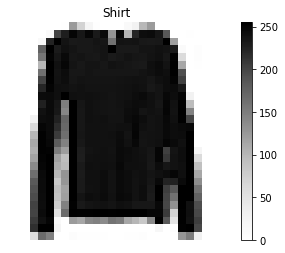

In [9]:
plt.figure()
plt.imshow(data_train[0,1:].reshape((28,28)),cmap='Greys')
plt.axis('off')
plt.title(class_label[int(data_train[0,0])])
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
#pixel data from -.5 to .5
x_train = data_train[:,1:]/255 -.5

#label data
y_train = data_train[:,0]

# data_validate format must be the same
data_submission = data_submission/255 -.5

In [11]:
x_train.shape, y_train.shape

((60000, 784), (60000,))

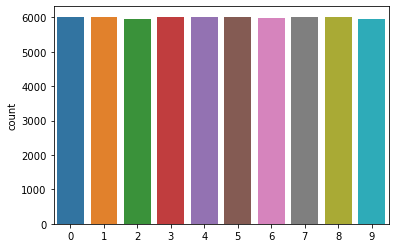

In [12]:
sns.countplot(x=np.array(y_train, dtype=np.int8));

In [13]:
data_submission.shape

(10000, 784)

In [14]:
# reshape the array containing the images (28px x 28px and 1 channel for black/white, 
#  3 channel for RGB) for convolutional layers
image_rows = 28
image_cols = 28
image_shape = (image_rows,image_cols,1)

x_train = x_train.reshape(x_train.shape[0],*image_shape)
data_submission = data_submission.reshape(data_submission.shape[0],*image_shape)

Hint: Use ImageDataGenerator: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [15]:
x_train.shape

(60000, 28, 28, 1)

In [16]:
#split train data in train and validation set
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)

In [17]:
print(x_train.shape, x_validate.shape)
print(y_train.shape,'         ', y_validate.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1)
(48000,)           (12000,)


# Which loss function is best? 

The aim of this chapter is to evaluate the best loss function on an architecture. We do this by taking a subset of the training. Then we train our models with the different loss functions. Note that all loss functions are trained with the same data. After the training we evaluate the accuracy with: 1. training sample and 2. validation sample for our loss functions. To ensure that we are statistically correct we repeat this `n_survey` times. We aggregate by taking the mean of all  `n_survey` as well as the variance.

In [31]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard# visualization
from tensorflow.keras.layers.experimental import preprocessing

# set random seed for dropouts
tf.random.set_seed(53124)

# set params and seed to reproduce code
np.random.seed(12498)
n_epoch = 4
n_survey = 6
n_models = 3
cnt = 0
# initialize accuracy and its variance
acc = np.zeros((n_epoch,n_models))
acc_sq = np.zeros((n_epoch,n_models))
# initialize validation accuracy and its variance
vacc = np.zeros((n_epoch,n_models))
vacc_sq = np.zeros((n_epoch,n_models))

for ii in np.random.randint(1,100000,n_survey):
    # split rain data in train and validation set, use different random states
    x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size = 0.2,random_state = ii)
    # update count
    print('__________ ',np.round(cnt/n_survey *100),'% __________')
    cnt += 1
    
    
    # iterate through different models
    for jj in range(n_models):
        if jj==0:
            ## sparse categorical crossentropy
            # simple baseline model (to beat)
            msimple = Sequential([
                Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dropout(.3),
                Dense(128, activation='relu'),
                Dropout(.3),
                Dense(10,activation='softmax')
            ])
            
            # compile model
            msimple.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
            
            # train model
            wsimple = msimple.fit(x_tr,y_tr,epochs=n_epoch,verbose=0,
                                  batch_size=64,
                                  validation_data=(x_validate,y_validate))
            
            print('\n sparse categorical crossentropy: ',end='')
            
            
        elif jj==1:
            ## categorical crossentropy
            # simple baseline model (to beat)
            msimple = Sequential([
                Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dropout(.3),
                Dense(128, activation='relu'),
                Dropout(.3),
                Dense(10,activation='softmax')
            ])
            
            # compile model
            msimple.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
            
            # train model
            wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                                  batch_size=64,
                                  validation_data=(x_validate,to_categorical(y_validate)))
            
            print('\n categorical crossentropy: ', end='')
            
            
        elif jj==2:
            ## categorical hinge
            # simple baseline model (to beat)
            msimple = Sequential([
                Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
                Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
                Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
                Flatten(),
                Dense(256, activation='relu'),
                Dropout(.3),
                Dense(128, activation='relu'),
                Dropout(.3),
                Dense(10,activation='softmax')
            ])
            
            # compile model
            msimple.compile(optimizer='adam',
                            loss='categorical_hinge',
                            metrics=['accuracy'])
            
            # train model
            wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                                  batch_size=64,
                                  validation_data=(x_validate,to_categorical(y_validate)))
            
            print('\n categorical hinge: ',end='')
            
        # save model acc
        tmp1 = wsimple.history['accuracy']
        acc[:,jj] += np.copy(tmp1) /n_survey
        acc_sq[:,jj] += np.copy(tmp1)**2 /n_survey
        tmp2 = wsimple.history['val_accuracy']
        vacc[:,jj] += np.copy(tmp2) /n_survey
        vacc_sq[:,jj] += np.copy(tmp2)**2 /n_survey
        print('acc ',np.round(np.max(tmp1),4),', val acc: ',np.round(np.max(tmp2),4))
    

__________  0.0 % __________

 sparse categorical crossentropy: acc  0.9 , val acc:  0.9

 categorical crossentropy: acc  0.9 , val acc:  0.89

 categorical hinge: acc  0.86 , val acc:  0.86
__________  17.0 % __________

 sparse categorical crossentropy: acc  0.9 , val acc:  0.89

 categorical crossentropy: acc  0.9 , val acc:  0.9

 categorical hinge: acc  0.86 , val acc:  0.86
__________  33.0 % __________

 sparse categorical crossentropy: acc  0.9 , val acc:  0.9

 categorical crossentropy: acc  0.9 , val acc:  0.9

 categorical hinge: acc  0.86 , val acc:  0.87
__________  50.0 % __________

 sparse categorical crossentropy: acc  0.9 , val acc:  0.9

 categorical crossentropy: acc  0.9 , val acc:  0.9

 categorical hinge: acc  0.86 , val acc:  0.86
__________  67.0 % __________

 sparse categorical crossentropy: acc  0.9 , val acc:  0.89

 categorical crossentropy: acc  0.9 , val acc:  0.89

 categorical hinge: acc  0.86 , val acc:  0.86
__________  83.0 % __________

 sparse cat

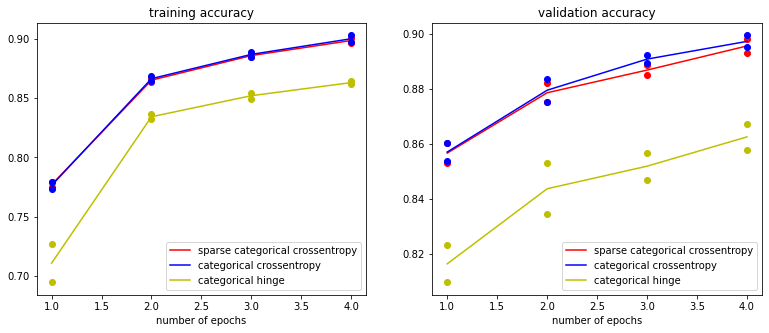

In [35]:
acc_std_err = (acc_sq - acc**2)**.5
vacc_std_err = (vacc_sq - vacc**2)**.5
models=['sparse categorical crossentropy','categorical crossentropy',
       'categorical hinge']
mcolor = ['r','b','y']

fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('training accuracy')
for jj in range(n_models):
    plt.plot(np.arange(1,5),acc[:,jj],mcolor[jj]+'-', label=models[jj]);
    plt.plot(np.arange(1,5),acc[:,jj]+acc_std_err[:,jj],mcolor[jj]+'o');
    plt.plot(np.arange(1,5),acc[:,jj]-acc_std_err[:,jj],mcolor[jj]+'o');
    plt.legend(loc='lower right');
    plt.xlabel('number of epochs');

plt.subplot(1,2,2)
plt.title('validation accuracy')
for jj in range(n_models):
    plt.plot(np.arange(1,5),vacc[:,jj],mcolor[jj]+'-', label=models[jj]);
    plt.plot(np.arange(1,5),vacc[:,jj]+vacc_std_err[:,jj],mcolor[jj]+'o');
    plt.plot(np.arange(1,5),vacc[:,jj]-vacc_std_err[:,jj],mcolor[jj]+'o');
    plt.legend(loc='lower right');
    plt.xlabel('number of epochs');

Solid lines in the plots indicate the mean over `n_survey` (=6) rounds. The dots are the standard errors. We conclude, that the `categorical_entropy` is the best loss for our model

# Which optimization function to use? 

We try to look at the best optimization function for our data and model in terms of accuracy. As we saw in the previous chapter, `categorical_entropy` is our loss function to use. Now in a similar fashion, we evaluate the optimization technique. Note that we just look at these functions with their default values. 

In [38]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard# visualization
from tensorflow.keras.layers.experimental import preprocessing

# set random seed for dropouts
tf.random.set_seed(53124)

# set params and seed to reproduce code
np.random.seed(12498)
n_epoch = 4
n_survey = 6
models=['Adam','Adagrad','SGD']
n_models = len(models)
cnt = 0
# initialize accuracy and its variance
acc = np.zeros((n_epoch,n_models))
acc_sq = np.zeros((n_epoch,n_models))
# initialize validation accuracy and its variance
vacc = np.zeros((n_epoch,n_models))
vacc_sq = np.zeros((n_epoch,n_models))

for ii in np.random.randint(1,100000,n_survey):
    # split rain data in train and validation set, use different random states
    x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size = 0.2,random_state = ii)
    # update count
    print('__________ ',np.round(cnt/n_survey *100),'% __________')
    cnt += 1
    
    
    # iterate through different models
    for jj in range(n_models):
        # simple baseline model (to beat)
        msimple = Sequential([
            Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
            Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
            Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(.3),
            Dense(128, activation='relu'),
            Dropout(.3),
            Dense(10,activation='softmax')
        ])

        # compile model
        if(jj!=2):
            msimple.compile(optimizer=models[jj],
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
        else:
            msimple.compile(optimizer=SGD(learning_rate=.01,momentum=.9,decay=.01),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
            
        # train model
        wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                              batch_size=64,
                              validation_data=(x_validate,to_categorical(y_validate)))
            
        print('\n ',models[jj], end=': ')
        
        # save model acc
        tmp1 = wsimple.history['accuracy']
        acc[:,jj] += np.copy(tmp1) /n_survey
        acc_sq[:,jj] += np.copy(tmp1)**2 /n_survey
        tmp2 = wsimple.history['val_accuracy']
        vacc[:,jj] += np.copy(tmp2) /n_survey
        vacc_sq[:,jj] += np.copy(tmp2)**2 /n_survey
        print('acc ',np.round(np.max(tmp1),4),', val acc: ',np.round(np.max(tmp2),4))
    

__________  0.0 % __________

  Adam: acc  0.8978 , val acc:  0.8984

  Adagrad: acc  0.6385 , val acc:  0.7249


C:\Users\Justus Thomsen\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



  SGD: acc  0.797 , val acc:  0.8167
__________  17.0 % __________

  Adam: acc  0.8972 , val acc:  0.8927

  Adagrad: acc  0.6652 , val acc:  0.7324

  SGD: acc  0.7989 , val acc:  0.8181
__________  33.0 % __________

  Adam: acc  0.8982 , val acc:  0.8958

  Adagrad: acc  0.6476 , val acc:  0.731

  SGD: acc  0.7962 , val acc:  0.8134
__________  50.0 % __________

  Adam: acc  0.8962 , val acc:  0.8965

  Adagrad: acc  0.6448 , val acc:  0.7209

  SGD: acc  0.7933 , val acc:  0.8133
__________  67.0 % __________

  Adam: acc  0.9025 , val acc:  0.8918

  Adagrad: acc  0.6661 , val acc:  0.727

  SGD: acc  0.7949 , val acc:  0.8136
__________  83.0 % __________

  Adam: acc  0.8989 , val acc:  0.8985

  Adagrad: acc  0.6504 , val acc:  0.722

  SGD: acc  0.7877 , val acc:  0.8062


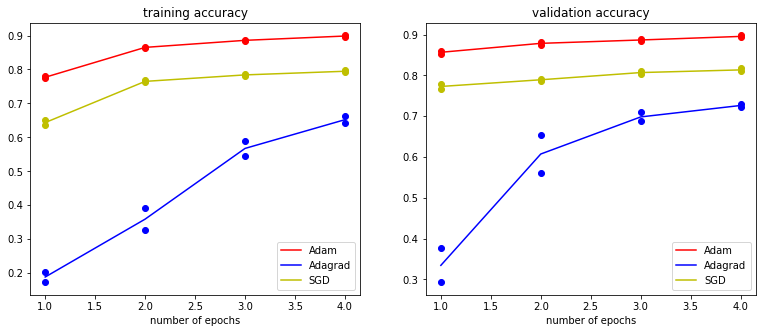

In [39]:
acc_std_err = (acc_sq - acc**2)**.5
vacc_std_err = (vacc_sq - vacc**2)**.5
mcolor = ['r','b','y']

fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('training accuracy')
for jj in range(n_models):
    plt.plot(np.arange(1,5),acc[:,jj],mcolor[jj]+'-', label=models[jj]);
    plt.plot(np.arange(1,5),acc[:,jj]+acc_std_err[:,jj],mcolor[jj]+'o');
    plt.plot(np.arange(1,5),acc[:,jj]-acc_std_err[:,jj],mcolor[jj]+'o');
    plt.legend(loc='lower right');
    plt.xlabel('number of epochs');

plt.subplot(1,2,2)
plt.title('validation accuracy')
for jj in range(n_models):
    plt.plot(np.arange(1,5),vacc[:,jj],mcolor[jj]+'-', label=models[jj]);
    plt.plot(np.arange(1,5),vacc[:,jj]+vacc_std_err[:,jj],mcolor[jj]+'o');
    plt.plot(np.arange(1,5),vacc[:,jj]-vacc_std_err[:,jj],mcolor[jj]+'o');
    plt.legend(loc='lower right');
    plt.xlabel('number of epochs');

Here the `adam` optimizer seems to be the best. However, if we look at the literature, e.g. https://arxiv.org/abs/1705.08292 or blog entries such as https://www.lightly.ai/post/which-optimizer-should-i-use-for-my-machine-learning-project, https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ we do not discard `SGD`. The performance of optimizers can only be verified after much more epochs. Including this in this notebook whould take ages. We trust the literature on this one.

# Now look at augmented data 

In [28]:
image = x_train[0]

In [29]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original, cmap='Greys')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented, cmap='Greys')
    plt.axis('off')


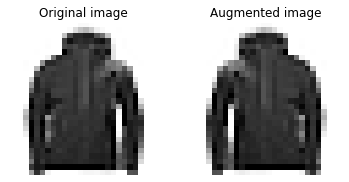

In [30]:
flipped = tf.image.flip_left_right(x_train[0:2])
visualize(image,flipped[0])

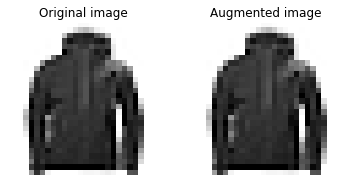

In [154]:
bright = tf.image.adjust_brightness(x_train[0:2], -.3)
visualize(image, bright[0])

In [155]:
print('Original image (min/max) ',np.min(image),'/',np.max(image))
print('Augmented image (min/max) ',np.min(bright),'/',np.max(bright))

Original image (min/max)  -0.5 / 0.5
Augmented image (min/max)  -0.8 / 0.19999999


maybe not the best idea to make it brighter, because boundaries change!
2nd idea: we change boundaries back to -.5 and .5

In [156]:
bright = np.array(bright, dtype=np.float32)
bright[bright>.5]=.5
bright[bright<-.5]=-.5

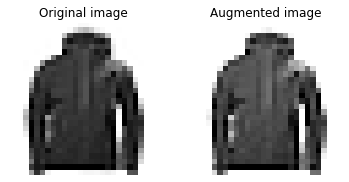

In [157]:
visualize(x_train[0], bright[0])

that actually looks good! 

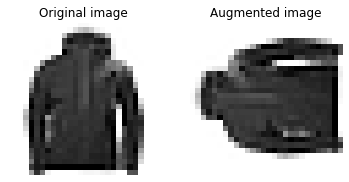

In [36]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

Now add all of the augmentations in a function 

In [52]:
np.random.seed(45854180)

In [54]:
def augment_image(X_image, brightness=.1, rotate=False, batch_size=100):
    # number of observations
    n=X_image.shape[0]
    # number of iterations with batch_size
    m=n//batch_size
    for ii in range(m):
        df_tmp = np.copy(X_image[(ii*batch_size):(ii*batch_size+batch_size)])
        # random if particular augmentation is done
        if np.random.rand(1)<.6:
            # flip
            df_tmp=tf.image.flip_left_right(df_tmp)
        if np.random.rand(1)<.7:
            # make brighter
            df_tmp=tf.image.adjust_brightness(df_tmp, -brightness)
            df_tmp=np.array(df_tmp, dtype=np.float32)
            df_tmp[df_tmp<-.5]= -.5
        else:
            # make darker
            df_tmp=tf.image.adjust_brightness(df_tmp, brightness)
            df_tmp=np.array(df_tmp, dtype=np.float32)            
            df_tmp[df_tmp>.5]=.5
        if rotate:
            for jj in range(3):
                if np.random.rand(1)<.4:
                    df_tmp = tf.image.rot90(df_tmp)
        
        # add to df
        X_image=np.vstack((X_image,df_tmp))
    
    # deal with the rest
    r = n%batch_size
    if r>0:
        df_tmp =np.copy(X_image[(n-r):n])
        # random if particular augmentation is done
        if np.random.rand(1)<.6:
            # flip
            df_tmp=tf.image.flip_left_right(df_tmp)
        if np.random.rand(1)<.7:
            # make brighter
            df_tmp=tf.image.adjust_brightness(df_tmp, -brightness)
            df_tmp=np.array(df_tmp, dtype=np.float32)
            df_tmp[df_tmp<-.5]= -.5
        else:
            # make darker
            df_tmp=tf.image.adjust_brightness(df_tmp, brightness)
            df_tmp=np.array(df_tmp, dtype=np.float32)
            df_tmp[df_tmp>.5]=.5
        if rotate:
            for jj in range(3):
                if np.random.rand(1)<.4:
                    df_tmp = tf.image.rot90(df_tmp)
        
        # add to df
        X_image=np.vstack((X_image,df_tmp))
    return X_image

In [55]:
x_train = augment_image(x_train)
y_train = np.array([y_train,y_train]).reshape(-1)

In [56]:
x_train = augment_image(x_train, brightness=.2,rotate=True)
y_train = np.array([y_train,y_train]).reshape(-1)

In [57]:
x_train=np.array(x_train, dtype=np.float32)

In [58]:
print(x_train.shape,y_train.shape)

(192000, 28, 28, 1) (192000,)


Sandal Sandal


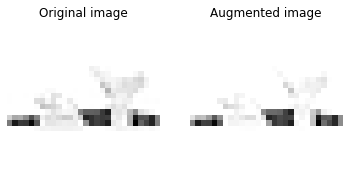

In [59]:
ii = 1000
visualize(x_train[ii], x_train[48000+ii])
print(class_label[int(y_train[ii])],class_label[int(y_train[48000+ii])])

Now look at a professional tool

In [39]:
# data augmentation
#import Augmentor

In [42]:
# set pipeline what data is used
#p = Augmentor.DataPipeline(x_train,y_train)

Not really working :/ 

*Hint: increase the size of the training set with data augmentation*
> https://www.tensorflow.org/tutorials/images/data_augmentation

### Modeling

Import [Keras](https://www.tensorflow.org/api_docs/python/tf/keras), a high-level API for TensorFlow

# try bagging!

In [60]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard# visualization
from tensorflow.keras.layers.experimental import preprocessing

# set random seed for dropouts
tf.random.set_seed(53124)

# data augmentation
data_augmentation = tf.keras.Sequential([
        preprocessing.RandomZoom(height_factor=0.2, width_factor=None, 
                                 fill_mode='reflect', interpolation='bilinear', seed=1234, fill_value=0.0),
        RandomRotation(factor=0.25, fill_mode='reflect', interpolation='bilinear', seed=1234, fill_value=0.0),
        RandomContrast(factor=0.2, seed=1234),
        #RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect', interpolation='bilinear', seed=1234, fill_value=0.0),
        preprocessing.RandomFlip(mode="horizontal_and_vertical", seed=1234)
])

# simple baseline model (to beat)
msimple = Sequential([
        Conv2D(kernel_size=3,filters=10,padding="same",activation='relu',input_shape=(28,28,1)),
        Flatten(),
        Dense(64,activation = 'relu'),
        Dense(10,activation = 'softmax')
    ])

# built more complex model
m1 = Sequential([
    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
    #MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(.3),
    Dense(128, activation='relu'),
    Dropout(.3),
    Dense(10,activation='softmax')
])

# increase #dense neurons
m2 = Sequential([
    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
    Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
    #MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.2),
    Dense(256, activation='relu'),
    Dropout(.2),
    Dense(10,activation='softmax')
])

In [61]:
msimple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
flatten (Flatten)            (None, 7840)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                501824    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 502,574
Trainable params: 502,574
Non-trainable params: 0
_________________________________________________________________


In [62]:
m1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               401664    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

*Hint: change the type, number and order of layers*
> https://www.tensorflow.org/api_docs/python/tf/keras/layers

*Hint: change the activation function*
> https://www.tensorflow.org/api_docs/python/tf/keras/activations

*Hint: prevent overfitting and speedup training by adding regularization*
> https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting

Choose an optimizer and loss function for training
Choose metric to evaluate performance

## Kompilieren des Modells
Bevor das Modell für das Training bereit ist, müssen einige weitere Einstellungen vorgenommen werden. 
Diese werden während des Kompilierungsschritts des Modells hinzugefügt:

Verlustfunktion - Hiermit wird gemessen, wie genau das Modell während des Trainings ist. Sie möchten diese Funktion minimieren, um das Modell in die richtige Richtung zu "steuern".

Optimierer - Auf diese Weise wird das Modell basierend auf den angezeigten Daten und seiner Verlustfunktion aktualisiert.

Metriken - Dient zum Überwachen der Trainings- und Testschritte. Im folgenden Beispiel wird die Genauigkeit verwendet , der Bruchteil der Bilder, die korrekt klassifiziert wurden.

In [96]:
msimple.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
m1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
m2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

*Hint: change the loss function*
> https://www.tensorflow.org/api_docs/python/tf/keras/losses

*Hint: change the optimization method and its parameters*
> https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

### Hyperparameter Tuning
For [optimizing hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_optimization) such as learning rate of SGD in an efficient and non-heuristic way, use a subset of your training data as validation set and perform Grid Search.

## Training

### 1. Train simple model without augmented data 

In [97]:
# shuffle raw data (no augmentation in first 48000 rows)
np.random.seed(458397)
r_idx_raw = np.arange(48000)
np.random.shuffle(r_idx_raw)

In [98]:
# batch_size default is 32 -> 48000/32=1500 training updates
wsimple_raw = msimple.fit(
    x_train[r_idx_raw],
    y_train[r_idx_raw],
    epochs=5,
    verbose=1,
    validation_data=(x_validate,y_validate)
    )

Epoch 1/5
1500/1500 [==============================] - 16s 10ms/step - loss: 0.4374 - accuracy: 0.8437 - val_loss: 0.3500 - val_accuracy: 0.8777
Epoch 2/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2982 - accuracy: 0.8931 - val_loss: 0.3200 - val_accuracy: 0.8869
Epoch 3/5
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2478 - accuracy: 0.9103 - val_loss: 0.2951 - val_accuracy: 0.8979
Epoch 4/5
1500/1500 [==============================] - 14s 10ms/step - loss: 0.2126 - accuracy: 0.9229 - val_loss: 0.3102 - val_accuracy: 0.8912
Epoch 5/5
1500/1500 [==============================] - 14s 9ms/step - loss: 0.1806 - accuracy: 0.9346 - val_loss: 0.2872 - val_accuracy: 0.9034


### 2. Train simple model with augmented data (flip, bright, no rotation)

In [99]:
# shuffle raw data (no augmentation in first 48000 rows)
np.random.seed(458397)
r_idx_fb = np.arange(48000*2)
np.random.shuffle(r_idx_fb)

In [100]:
wsimple_fb = msimple.fit(
    x_train[r_idx_fb],
    y_train[r_idx_fb],
    epochs=5,
    verbose=1,
    validation_data=(x_validate,y_validate)
    )

Epoch 1/5
3000/3000 [==============================] - 28s 9ms/step - loss: 0.2246 - accuracy: 0.9202 - val_loss: 0.3058 - val_accuracy: 0.9004
Epoch 2/5
3000/3000 [==============================] - 27s 9ms/step - loss: 0.1651 - accuracy: 0.9406 - val_loss: 0.3007 - val_accuracy: 0.9068
Epoch 3/5
3000/3000 [==============================] - 27s 9ms/step - loss: 0.1332 - accuracy: 0.9529 - val_loss: 0.3247 - val_accuracy: 0.9031
Epoch 4/5
3000/3000 [==============================] - 27s 9ms/step - loss: 0.1075 - accuracy: 0.9616 - val_loss: 0.3514 - val_accuracy: 0.9025
Epoch 5/5
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0865 - accuracy: 0.9685 - val_loss: 0.3757 - val_accuracy: 0.9049


### 3. Train simple model with full augmented data (flip, bright, rotation)

In [101]:
# shuffle raw data (no augmentation in first 48000 rows)
np.random.seed(458397)
r_idx_fbr = np.arange(48000*2*2)
np.random.shuffle(r_idx_fbr)

In [102]:
wsimple_fbr = msimple.fit(
    x_train[r_idx_fbr],
    y_train[r_idx_fbr],
    epochs=5,
    verbose=1,
    validation_data=(x_validate,y_validate)
    )

Epoch 1/5
6000/6000 [==============================] - 54s 9ms/step - loss: 0.4254 - accuracy: 0.8600 - val_loss: 0.3254 - val_accuracy: 0.8988
Epoch 2/5
6000/6000 [==============================] - 53s 9ms/step - loss: 0.2716 - accuracy: 0.9063 - val_loss: 0.3372 - val_accuracy: 0.8963
Epoch 3/5
6000/6000 [==============================] - 52s 9ms/step - loss: 0.2201 - accuracy: 0.9240 - val_loss: 0.3745 - val_accuracy: 0.8979
Epoch 4/5
6000/6000 [==============================] - 52s 9ms/step - loss: 0.1844 - accuracy: 0.9357 - val_loss: 0.4010 - val_accuracy: 0.8950
Epoch 5/5
6000/6000 [==============================] - 55s 9ms/step - loss: 0.1531 - accuracy: 0.9463 - val_loss: 0.4505 - val_accuracy: 0.8954


In [104]:
# save the weights
wsimple_raw.model.save_weights('cnn.msimple_raw')
wsimple_fb.model.save_weights('cnn.msimple_fb')
wsimple_fbr.model.save_weights('cnn.msimple_fbr')

Plot accuray

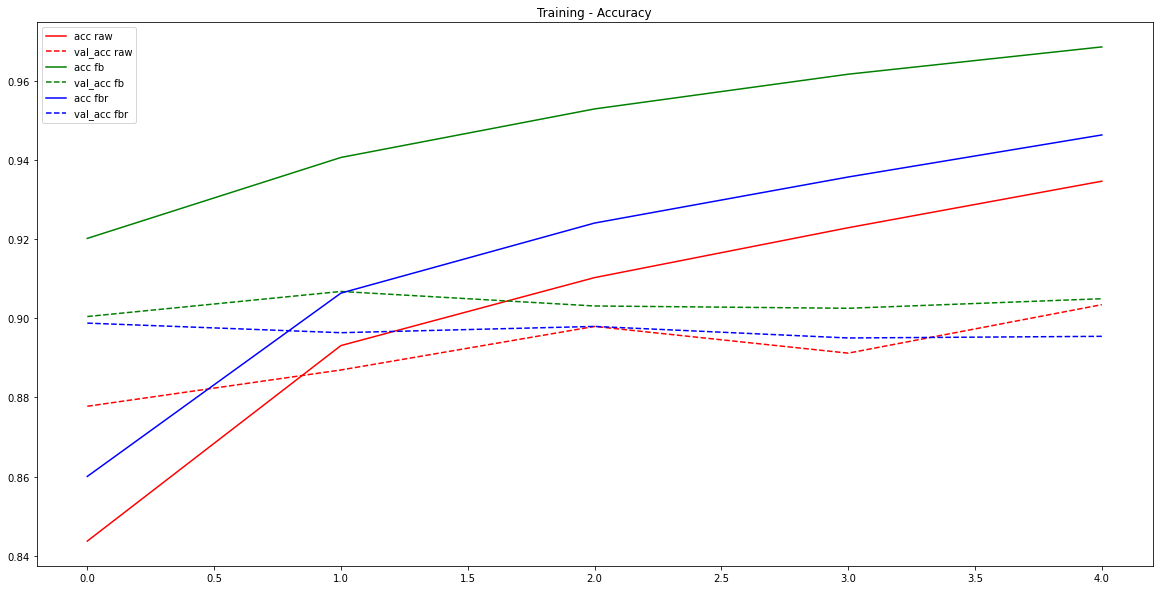

In [109]:
plt.figure(figsize=(20, 10))
plt.plot(wsimple_raw.history['accuracy'],'r-', label='acc raw')
plt.plot(wsimple_raw.history['val_accuracy'],'r--', label='val_acc raw')
plt.plot(wsimple_fb.history['accuracy'],'g-', label='acc fb')
plt.plot(wsimple_fb.history['val_accuracy'],'g--', label='val_acc fb')
plt.plot(wsimple_fbr.history['accuracy'],'b-', label='acc fbr')
plt.plot(wsimple_fbr.history['val_accuracy'],'b--', label='val_acc fbr')
plt.title('Training - Accuracy');
plt.legend()
plt.show();

No rotation, but augmentation with flip and brightness change seem to perform not bad. Thus, proceed with flipped and bright augmented data

In [103]:
w1 = m1.fit(
    x_train[r_idx_fb],
    y_train[r_idx_fb],
    batch_size=32,
    epochs=8,
    verbose=1,
    validation_data=(x_validate,y_validate)
    )

Epoch 1/8
3000/3000 [==============================] - 63s 21ms/step - loss: 0.4751 - accuracy: 0.8293 - val_loss: 0.3131 - val_accuracy: 0.8875
Epoch 2/8
3000/3000 [==============================] - 58s 19ms/step - loss: 0.2977 - accuracy: 0.8929 - val_loss: 0.2934 - val_accuracy: 0.8962
Epoch 3/8
3000/3000 [==============================] - 62s 21ms/step - loss: 0.2492 - accuracy: 0.9106 - val_loss: 0.2701 - val_accuracy: 0.9057
Epoch 4/8
3000/3000 [==============================] - 63s 21ms/step - loss: 0.2150 - accuracy: 0.9217 - val_loss: 0.2599 - val_accuracy: 0.9086
Epoch 5/8
3000/3000 [==============================] - 69s 23ms/step - loss: 0.1872 - accuracy: 0.9309 - val_loss: 0.2757 - val_accuracy: 0.9082
Epoch 6/8
3000/3000 [==============================] - 67s 22ms/step - loss: 0.1643 - accuracy: 0.9399 - val_loss: 0.2827 - val_accuracy: 0.9128
Epoch 7/8
3000/3000 [==============================] - 62s 21ms/step - loss: 0.1478 - accuracy: 0.9455 - val_loss: 0.2785 - val_ac

In [105]:
# save the weights
w1.model.save_weights('cnn.m1_fb')

In [106]:
w2 = m2.fit(
    x_train[r_idx_fb],
    y_train[r_idx_fb],
    batch_size=32,
    epochs=8,
    verbose=1,
    validation_data=(x_validate,y_validate)
)

Epoch 1/8
3000/3000 [==============================] - 74s 25ms/step - loss: 0.4182 - accuracy: 0.8483 - val_loss: 0.3067 - val_accuracy: 0.8883
Epoch 2/8
3000/3000 [==============================] - 72s 24ms/step - loss: 0.2626 - accuracy: 0.9043 - val_loss: 0.2588 - val_accuracy: 0.9058
Epoch 3/8
3000/3000 [==============================] - 69s 23ms/step - loss: 0.2094 - accuracy: 0.9229 - val_loss: 0.2816 - val_accuracy: 0.9053
Epoch 4/8
3000/3000 [==============================] - 70s 23ms/step - loss: 0.1750 - accuracy: 0.9352 - val_loss: 0.2551 - val_accuracy: 0.9143
Epoch 5/8
3000/3000 [==============================] - 73s 24ms/step - loss: 0.1486 - accuracy: 0.9448 - val_loss: 0.2689 - val_accuracy: 0.9150
Epoch 6/8
3000/3000 [==============================] - 71s 24ms/step - loss: 0.1257 - accuracy: 0.9535 - val_loss: 0.3089 - val_accuracy: 0.9158
Epoch 7/8
3000/3000 [==============================] - 75s 25ms/step - loss: 0.1062 - accuracy: 0.9604 - val_loss: 0.3436 - val_ac

In [107]:
# save the weights
w2.model.save_weights('cnn.m2_fb')

### Plot Loss 

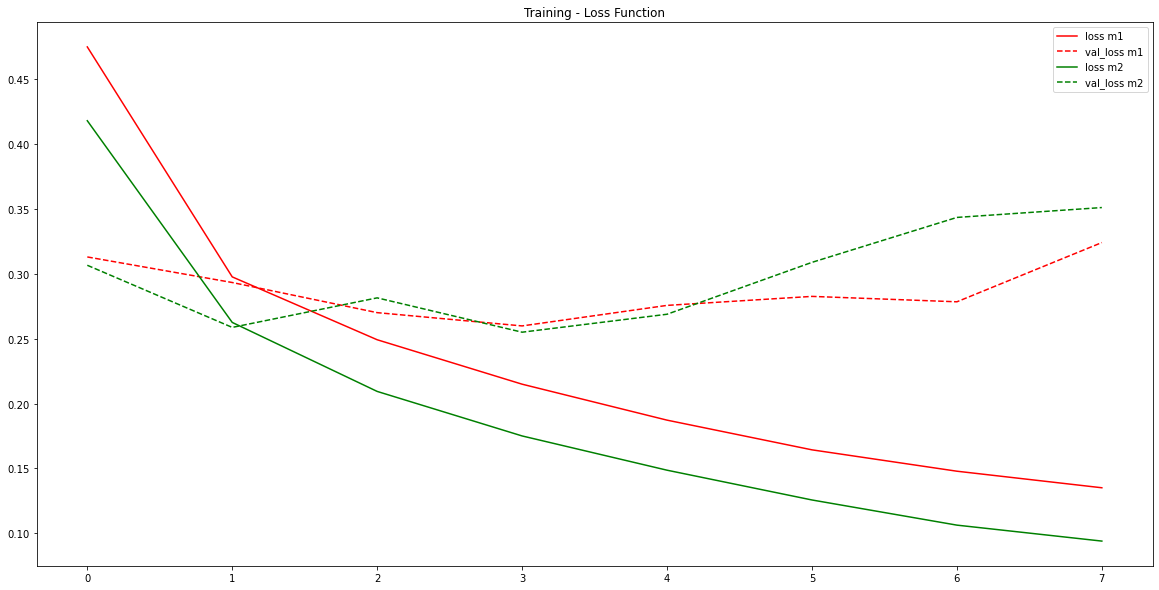

In [110]:
plt.figure(figsize=(20, 10))
plt.plot(w1.history['loss'],'r-', label='loss m1')
plt.plot(w1.history['val_loss'],'r--', label='val_loss m1')
plt.plot(w2.history['loss'],'g-', label='loss m2')
plt.plot(w2.history['val_loss'],'g--', label='val_loss m2')
plt.title('Training - Loss Function');
plt.legend()
plt.show();

In [111]:
from sklearn.metrics import confusion_matrix

In [114]:
predictions = m2.predict(x_validate).argmax(axis=1)
cm = confusion_matrix(y_validate,predictions)

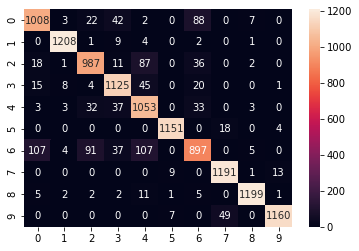

In [115]:
# HeatMap
sns.heatmap(cm , annot = True,fmt = 'd',xticklabels = range(10),yticklabels = range(10));

### Plot Accuracy

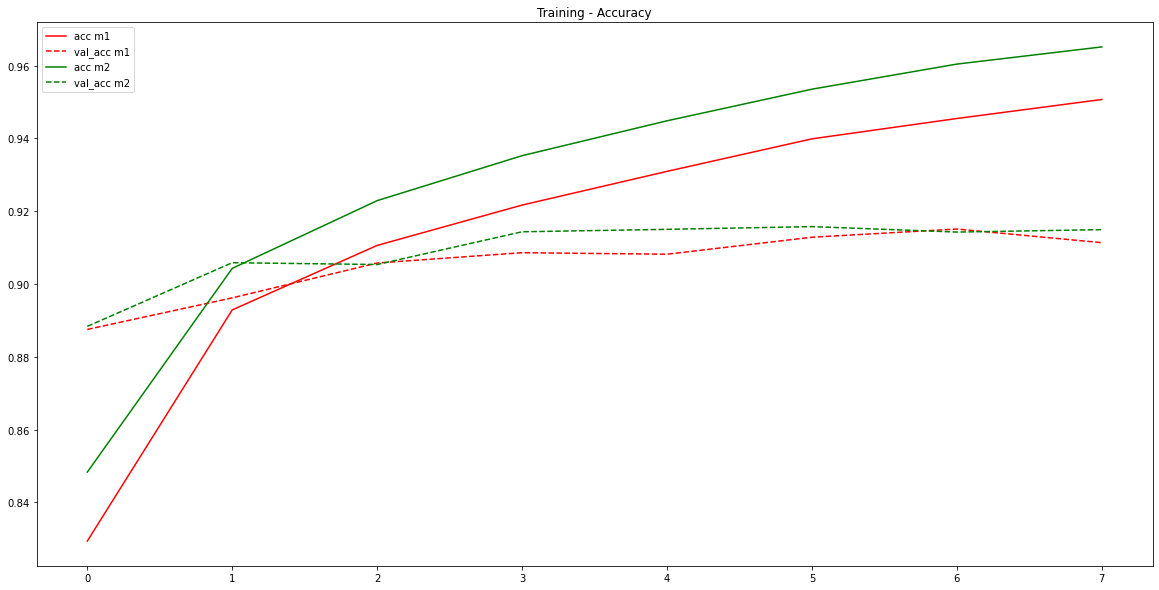

In [117]:
plt.figure(figsize=(20, 10))
plt.plot(w1.history['accuracy'],'r-', label='acc m1')
plt.plot(w1.history['val_accuracy'],'r--', label='val_acc m1')
plt.plot(w2.history['accuracy'],'g-', label='acc m2')
plt.plot(w2.history['val_accuracy'],'g--', label='val_acc m2')
plt.title('Training - Accuracy');
plt.legend()
plt.show();

### Plot Missclassified

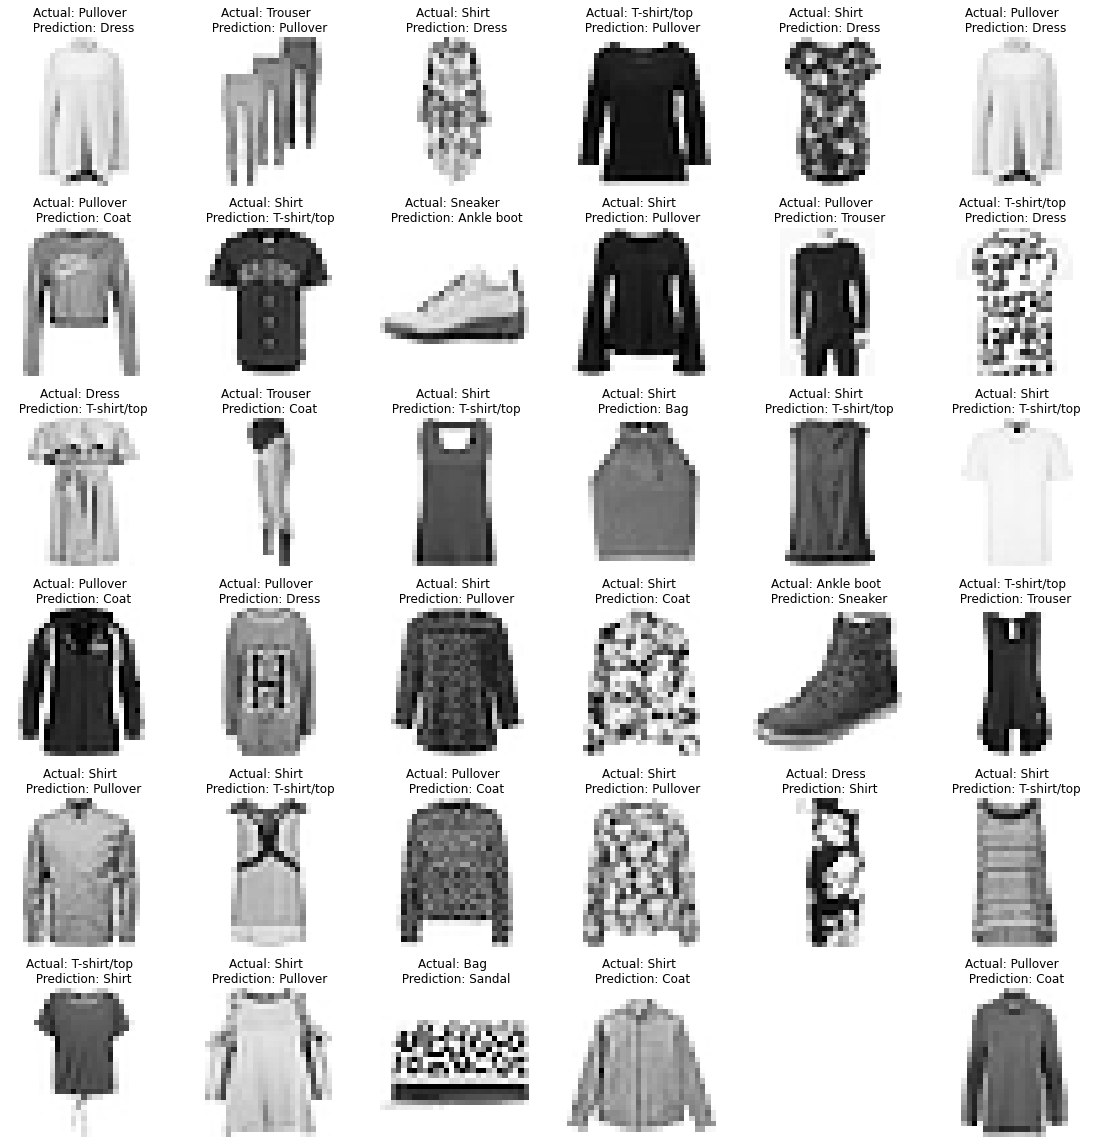

In [118]:
misclassified_idx = np.where(predictions != y_validate)[0]
mis_r_idx = np.random.choice(misclassified_idx,36)
plt.figure(figsize=(16,16))
j = 1
for i in mis_r_idx:
    plt.subplot(6,6,j); j+=1
    plt.imshow(x_validate[i],cmap = 'Greys')
    plt.axis('off')
    plt.tight_layout()
    plt.title('Actual: {} \n Prediction: {}'.format(class_label[int(y_validate[i])],
                                                    class_label[predictions[i]]));

## What does data augmentation?

Data augmentation is changing the data a bit to ensure that model really learns the structure of the object. Here we look at two approaches: 1. train with normal data and evaluate with an augmentation fan (`augmented_val_grid`) which is then aggregated, 2. train with augmentation fan and evaluate with augmentation fan (same as for training) which is then aggregated. 

In [18]:
def augmented_val_grid(X_image, brightness=.1):
    '''
    Augments the valuation data in deterministic way
    Parameters
    ----------
    X_image:     dataframe with images
    brightness:  changes the brightness in each direction (basically just adds value to pixel values)
    
    Returns
    -------
    dataframe with size six times X_image in first dimension (1 X_image, 2 X_image flipped left right, 
    3 X_image brighter, 4 X_image flipped brighter, 5 X_image darker, 6 X_image flipped darker)
    '''
    # number of observations
    n=X_image.shape[0]
    tmp_f = np.copy(X_image)
    # flip
    tmp_f=tf.image.flip_left_right(tmp_f)
    
    # make brighter
    tmp_b=tf.image.adjust_brightness(X_image, -brightness)
    tmp_b=np.array(tmp_b, dtype=np.float32)
    tmp_b[tmp_b<-.5]= -.5
    tmp_fb=tf.image.adjust_brightness(tmp_f, -brightness)
    tmp_fb=np.array(tmp_fb, dtype=np.float32)
    tmp_fb[tmp_fb<-.5]= -.5
    
    # make darker
    tmp_d=tf.image.adjust_brightness(X_image, brightness)
    tmp_d=np.array(tmp_d, dtype=np.float32)            
    tmp_d[tmp_d>.5]=.5
    tmp_fd=tf.image.adjust_brightness(tmp_f, brightness)
    tmp_fd=np.array(tmp_fd, dtype=np.float32)            
    tmp_fd[tmp_fd>.5]=.5
    
    # add to df
    X_image=np.vstack((X_image,tmp_f,tmp_b,tmp_fb,tmp_d,tmp_fd))
    return X_image

In [19]:
x_validate_aug_grid = augmented_val_grid(x_validate, brightness=.2)
x_validate.shape

(12000, 28, 28, 1)

In [50]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard# visualization
from tensorflow.keras.layers.experimental import preprocessing

# set random seed for dropouts
tf.random.set_seed(53124)

# set params and seed to reproduce code
np.random.seed(12498)
n_epoch = 4
n_survey = 6
models=['raw','augging']
n_models = len(models)
cnt = 0
# initialize accuracy and its variance
acc = np.zeros((1,n_models))
acc_sq = np.zeros((1,n_models))
# initialize validation accuracy and its variance
vacc = np.zeros((1,n_models))
vacc_sq = np.zeros((1,n_models))

for ii in np.random.randint(1,100000,n_survey):
    # split rain data in train and validation set, use different random states
    x_tr,x_val,y_tr,y_val = train_test_split(x_train,y_train,test_size = 0.2,random_state = ii)
    # update count
    print('__________ ',np.round(cnt/n_survey *100),'% __________')
    cnt += 1

    # simple baseline model (to beat)
    # note that this model is trained w/o augmentation
    msimple = Sequential([
        Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
        Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
        Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(.3),
        Dense(128, activation='relu'),
        Dropout(.3),
        Dense(10,activation='softmax')
    ])

    # compile model
    msimple.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
            
    # train model
    wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                          batch_size=64,
                          validation_data=(x_validate,to_categorical(y_validate)))
    
    # save model acc raw
    tmp = wsimple.history
    acc[:,0] += np.max(tmp['accuracy']) /n_survey
    acc_sq[:,0] += np.max(tmp['accuracy'])**2 /n_survey
    vacc[:,0] += np.max(tmp['val_accuracy']) /n_survey
    vacc_sq[:,0] += np.max(tmp['val_accuracy'])**2 /n_survey
    print('raw: acc ',np.round(np.max(tmp['accuracy']),4),', val acc ',np.round(np.max(tmp['val_accuracy']),4))
            
    # save model acc with augmentation and aggregation
    x_tr_aug_grid = augmented_val_grid(x_tr, brightness=.2)
    tmp1 = msimple.predict(x_tr_aug_grid)
    n_tr = len(y_tr)
    y_tr_agg = np.empty(n_tr)
    for ii in range(n_tr):
        y_tr_agg[ii]=np.mean(tmp1[np.arange(6)*n_tr+ii,:],axis=0).argmax()
    acc[:,1] += np.sum(np.equal(y_tr_agg,y_tr))/n_tr /n_survey
    acc_sq[:,1] += (np.sum(np.equal(y_tr_agg,y_tr))/n_tr)**2 /n_survey
    
    tmp2 = msimple.predict(x_validate_aug_grid)
    n_val = len(y_validate)
    y_val_agg = np.empty(n_val)
    for ii in range(n_val):
        y_val_agg[ii]=np.mean(tmp2[np.arange(6)*n_val+ii,:],axis=0).argmax()
    vacc[:,1] += np.sum(np.equal(y_val_agg,y_validate))/n_val /n_survey
    vacc_sq[:,1] += (np.sum(np.equal(y_val_agg,y_validate))/n_val)**2 /n_survey
    print('augging: acc ',np.round(np.sum(np.equal(y_tr_agg,y_tr))/n_tr,4),
          ', val acc ',np.round(np.sum(np.equal(y_val_agg,y_validate))/n_val,4))
    

__________  0.0 % __________
raw: acc  0.8978 , val acc  0.8984
augging: acc  0.84 , val acc  0.8237
__________  17.0 % __________
raw: acc  0.8976 , val acc  0.8949
augging: acc  0.797 , val acc  0.7841
__________  33.0 % __________
raw: acc  0.8966 , val acc  0.8982
augging: acc  0.7786 , val acc  0.7624
__________  50.0 % __________
raw: acc  0.8974 , val acc  0.8983
augging: acc  0.797 , val acc  0.7763
__________  67.0 % __________
raw: acc  0.8999 , val acc  0.8924
augging: acc  0.8454 , val acc  0.8242
__________  83.0 % __________
raw: acc  0.8975 , val acc  0.8982
augging: acc  0.8139 , val acc  0.7937


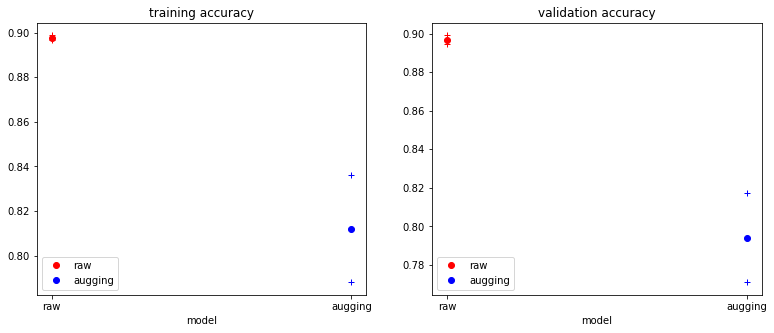

In [54]:
acc_std_err = (acc_sq - acc**2)**.5
vacc_std_err = (vacc_sq - vacc**2)**.5
mcolor = ['r','b']

fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('training accuracy')
for jj in range(n_models):
    plt.plot(models[jj],acc[:,jj],mcolor[jj]+'o', label=models[jj]);
    plt.plot(models[jj],acc[:,jj]+acc_std_err[:,jj],mcolor[jj]+'+');
    plt.plot(models[jj],acc[:,jj]-acc_std_err[:,jj],mcolor[jj]+'+');
    plt.legend(loc='lower center');
    plt.xlabel('model');

plt.subplot(1,2,2)
plt.title('validation accuracy')
for jj in range(n_models):
    plt.plot(models[jj],vacc[:,jj],mcolor[jj]+'o', label=models[jj]);
    plt.plot(models[jj],vacc[:,jj]+vacc_std_err[:,jj],mcolor[jj]+'+');
    plt.plot(models[jj],vacc[:,jj]-vacc_std_err[:,jj],mcolor[jj]+'+');
    plt.legend(loc='lower center');
    plt.xlabel('model');

Augmentation in validation makes no sense if we did not train for it. But what about the augmentation validation if we also trained for it?

In [20]:
x_train_grid = augmented_val_grid(x_train)
y_train_grid = np.array([y_train,y_train,y_train,y_train,y_train,y_train]).reshape(-1)

In [21]:
x_train_grid.shape, y_train_grid.shape

((288000, 28, 28, 1), (288000,))

In [22]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard# visualization
from tensorflow.keras.layers.experimental import preprocessing

# set random seed for dropouts
tf.random.set_seed(53124)

# set params and seed to reproduce code
np.random.seed(12498)
n_epoch = 4
n_survey = 6
models=['raw','augging']
n_models = len(models)
cnt = 0
# initialize accuracy and its variance
acc = np.zeros((1,n_models))
acc_sq = np.zeros((1,n_models))
# initialize validation accuracy and its variance
vacc = np.zeros((1,n_models))
vacc_sq = np.zeros((1,n_models))

for ii in np.random.randint(1,100000,n_survey):
    # split rain data in train and validation set, use different random states
    x_tr,x_val,y_tr,y_val = train_test_split(x_train_grid,y_train_grid,test_size = 0.2,random_state = ii)
    # update count
    print('__________ ',np.round(cnt/n_survey *100),'% __________')
    cnt += 1

    # simple baseline model (to beat)
    # note that this model is trained w/o augmentation
    msimple = Sequential([
        Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu',input_shape=(28,28,1)),
        Conv2D(64,(3,3),strides=(2,2),padding='same',activation='relu'),
        Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(.3),
        Dense(128, activation='relu'),
        Dropout(.3),
        Dense(10,activation='softmax')
    ])

    # compile model
    msimple.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
            
    # train model
    wsimple = msimple.fit(x_tr,to_categorical(y_tr),epochs=n_epoch,verbose=0,
                          batch_size=64,
                          validation_data=(x_validate,to_categorical(y_validate)))
    
    # remove from memory
    del x_tr
    
    # save model acc raw
    tmp = wsimple.history
    acc[:,0] += np.max(tmp['accuracy']) /n_survey
    acc_sq[:,0] += np.max(tmp['accuracy'])**2 /n_survey
    vacc[:,0] += np.max(tmp['val_accuracy']) /n_survey
    vacc_sq[:,0] += np.max(tmp['val_accuracy'])**2 /n_survey
    print('raw: acc ',np.round(np.max(tmp['accuracy']),4),', val acc ',np.round(np.max(tmp['val_accuracy']),4))
            
    # save model acc with augmentation and aggregation
    #x_tr_aug_grid = augmented_val_grid(x_tr, brightness=.2)
    #tmp1 = msimple.predict(x_tr_aug_grid)
    #n_tr = len(y_tr)
    #y_tr_agg = np.empty(n_tr)
    #for ii in range(n_tr):
    #    y_tr_agg[ii]=np.mean(tmp1[np.arange(6)*n_tr+ii,:],axis=0).argmax()
    #acc[:,1] += np.sum(np.equal(y_tr_agg,y_tr))/n_tr /n_survey
    #acc_sq[:,1] += (np.sum(np.equal(y_tr_agg,y_tr))/n_tr)**2 /n_survey
    
    tmp2 = msimple.predict(x_validate_aug_grid)
    n_val = len(y_validate)
    y_val_agg = np.empty(n_val)
    for ii in range(n_val):
        y_val_agg[ii]=np.mean(tmp2[np.arange(6)*n_val+ii,:],axis=0).argmax()
    vacc[:,1] += np.sum(np.equal(y_val_agg,y_validate))/n_val /n_survey
    vacc_sq[:,1] += (np.sum(np.equal(y_val_agg,y_validate))/n_val)**2 /n_survey
    print('augging: acc ','RAM too small',#np.round(np.sum(np.equal(y_tr_agg,y_tr))/n_tr,4),
          ', val acc ',np.round(np.sum(np.equal(y_val_agg,y_validate))/n_val,4))
    

__________  0.0 % __________
raw: acc  0.9482 , val acc  0.9199
augging: acc  RAM too small , val acc  0.9216
__________  17.0 % __________
raw: acc  0.949 , val acc  0.9196
augging: acc  RAM too small , val acc  0.9213
__________  33.0 % __________
raw: acc  0.9487 , val acc  0.9157
augging: acc  RAM too small , val acc  0.9173
__________  50.0 % __________
raw: acc  0.9486 , val acc  0.918
augging: acc  RAM too small , val acc  0.9183
__________  67.0 % __________
raw: acc  0.9495 , val acc  0.9159
augging: acc  RAM too small , val acc  0.9182
__________  83.0 % __________
raw: acc  0.948 , val acc  0.9197
augging: acc  RAM too small , val acc  0.9198


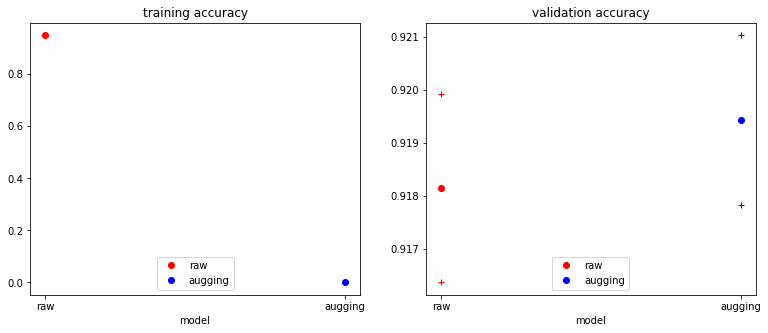

In [26]:
acc_std_err = (acc_sq - acc**2)**.5
vacc_std_err = (vacc_sq - vacc**2)**.5
mcolor = ['r','b']

fig = plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('training accuracy')
for jj in range(n_models):
    plt.plot(models[jj],acc[:,jj],mcolor[jj]+'o', label=models[jj]);
    plt.plot(models[jj],acc[:,jj]+acc_std_err[:,jj],mcolor[jj]+'+');
    plt.plot(models[jj],acc[:,jj]-acc_std_err[:,jj],mcolor[jj]+'+');
    plt.legend(loc='lower center');
    plt.xlabel('model');

plt.subplot(1,2,2)
plt.title('validation accuracy')
for jj in range(n_models):
    plt.plot(models[jj],vacc[:,jj],mcolor[jj]+'o', label=models[jj]);
    plt.plot(models[jj],vacc[:,jj]+vacc_std_err[:,jj],mcolor[jj]+'+');
    plt.plot(models[jj],vacc[:,jj]-vacc_std_err[:,jj],mcolor[jj]+'+');
    plt.legend(loc='lower center');
    plt.xlabel('model');

Plot shows the accuracy of the raw and the augmented aggregating models. Note that data augmentation in training has a huge impact! If we compare these plots with the accuracy w/o augmentation we now have an accuracy over 91% instead of an accuracy of a bit lower than 90%. Thus, data augmentation is very useful. How about validation with augmentation? In the plots here we see that the validation accuracy mean is higher than the one without. The difference is not significant since the confidence intervals with one standard devation intersect on around 91,8% and 92% of accuracy. However, we still conclude that augmenting the validation data set in the same way we augmented the training data and the take the mean boosts the accuracy and we should use it.

### Submission
Submit your final notebook as **fashion_mnist_teamX.ipynb** and your predictions of the test data as a **predictions_teamX.csv**.

In [31]:
# predict results
results = model.predict(data_submission)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
results

NameError: name 'model' is not defined

In [ ]:
data_results = pd.DataFrame(results)
data_results.head(10)

In [ ]:
# Submission of group 1
data_results.to_csv('fashion_mnist_pred_team1.csv', index=False) 

## Ressources
Background:
  * Book: [Neural Networks and Deep Learning, Michael Nielsen](http://neuralnetworksanddeeplearning.com) 
  * Lecture: [CS231n, Stanford University](http://cs231n.stanford.edu/)

Implementation:
  * [TensorFlow tutorials](https://www.tensorflow.org/tutorials)
  * [Keras Docs](https://www.tensorflow.org/api_docs/python/tf/keras)

## Image Sources
* http://neuralnetworksanddeeplearning.com/images/
* https://www.researchgate.net/publication/320270458/figure/fig1/AS:551197154254848@1508427050805/Mathematical-model-of-artificial-neuron.png
* https://www.w3resource.com/w3r_images/numpy-manipulation-ndarray-flatten-function-image-1.png
* https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png
* https://glassboxmedicine.files.wordpress.com/2019/01/slide2.jpg?w=616
* http://neuralnetworksanddeeplearning.com/images/valley_with_ball.png
* https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png